<a href="https://colab.research.google.com/github/shawiii217/demo/blob/main/Diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -q scikit-plot shap xgboost imbalanced-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
import joblib
import shap

RANDOM_STATE = 42
rcParams['figure.figsize'] = (8,5)
sns.set_style("whitegrid")


In [2]:

possible_paths = [
    "/content/diabetes.csv",
    "diabetes.csv",
    "/mnt/data/Project_3/diabetes.csv",
    "/mnt/data/diabetes.csv"
]

for p in possible_paths:
    if os.path.exists(p):
        DATA_PATH = p
        break
else:
    raise FileNotFoundError("diabetes.csv not found. Upload to /content or adjust path.")

df = pd.read_csv(DATA_PATH)
print("Loaded from:", DATA_PATH)
print("Shape:", df.shape)
df.head()


Loaded from: /content/diabetes.csv
Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Data types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Summary statistics:
                           count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   

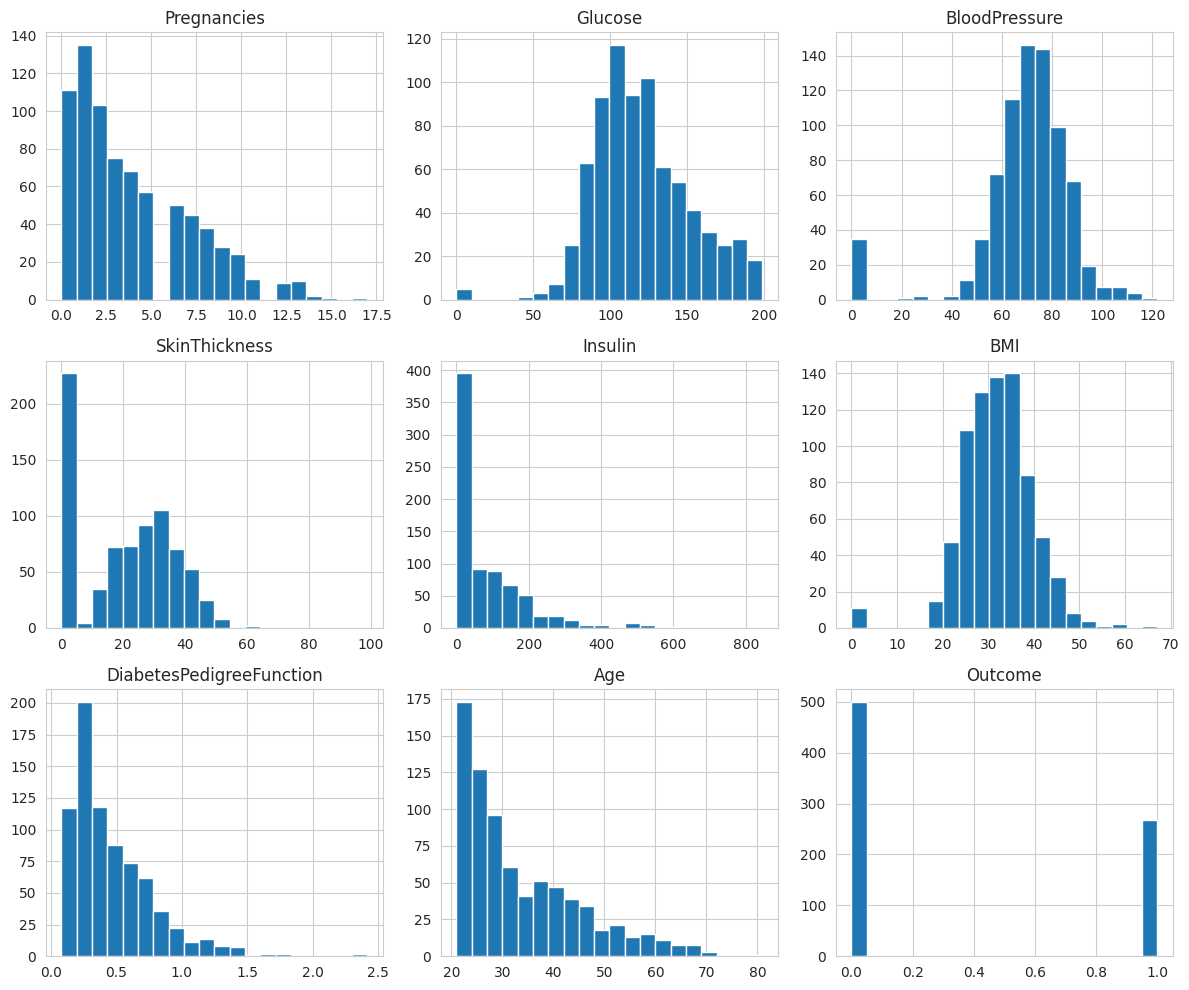

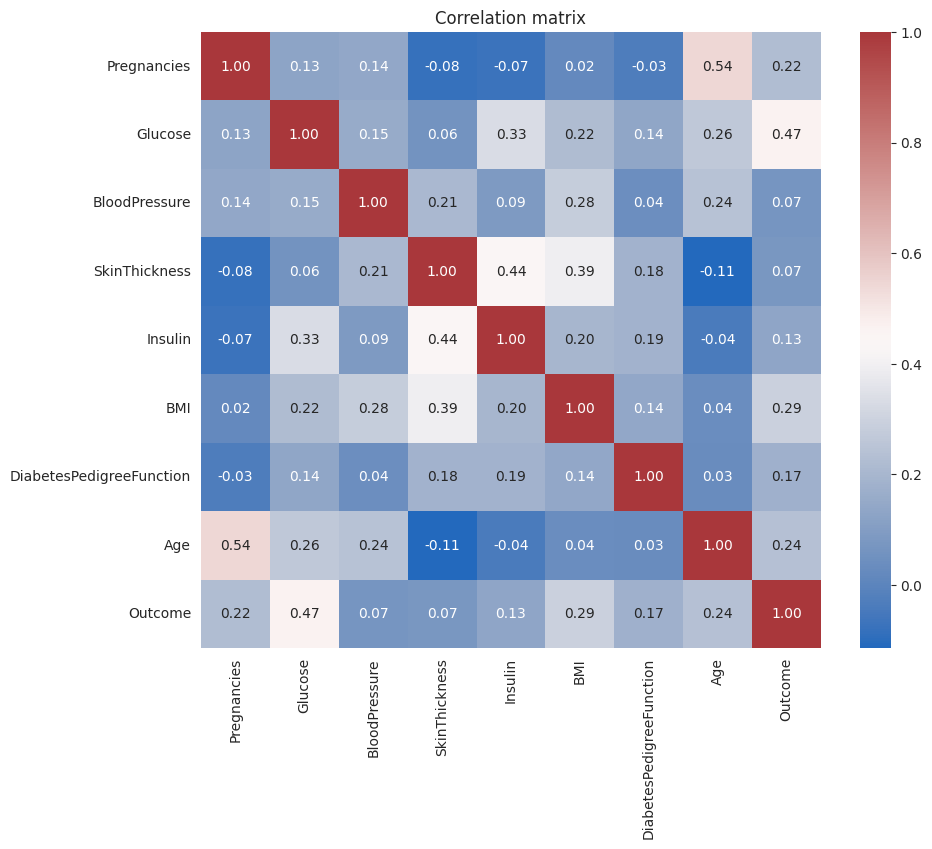

In [3]:
# Basic checks
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe().T)

# Class distribution
print("\nOutcome value counts:\n", df['Outcome'].value_counts(normalize=False))
print("\nOutcome distribution (percent):\n", df['Outcome'].value_counts(normalize=True).round(3))

# Visualize distributions
df.hist(bins=20, figsize=(12,10))
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix")
plt.show()


In [4]:
# Some features can't be zero (glucose, blood pressure, skin thickness, insulin, BMI)
# Replace zeros with np.nan then consider imputation (median)
cols_with_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zero:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

print("Missing after zero->NaN replacement:\n", df[cols_with_zero].isnull().sum())

# Impute with median
for col in cols_with_zero:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print("After imputation missing counts:\n", df.isnull().sum())


Missing after zero->NaN replacement:
 Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64
After imputation missing counts:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-3416506925.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [5]:
TARGET = "Outcome"
X = df.drop(columns=[TARGET])
y = df[TARGET]

feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (614, 8) Test shape: (154, 8)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Apply SMOTE to training set only (if imbalance)
print("Before SMOTE class distribution:", np.bincount(y_train))
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)
print("After SMOTE class distribution:", np.bincount(y_train_res))


Before SMOTE class distribution: [400 214]
After SMOTE class distribution: [400 400]


In [7]:
models = {
    "Logistic": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "SVM": SVC(random_state=RANDOM_STATE, probability=True),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test_scaled)
    probs = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs) if probs is not None else None
    results[name] = {"accuracy": acc, "auc": auc}

pd.DataFrame(results).T


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:51:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,accuracy,auc
Logistic,0.714286,0.811481
SVM,0.727273,0.811389
RandomForest,0.753247,0.814167
XGBoost,0.727273,0.807963


In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, scaler.transform(X), y, cv=cv, scoring='roc_auc')
    cv_scores[name] = scores.mean()
pd.Series(cv_scores).sort_values(ascending=False)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:51:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:51:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:51:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:51:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:51:56] WARNING: /w

,0
Logistic,0.836516
SVM,0.822603
RandomForest,0.822005
XGBoost,0.796471


In [9]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, None],
    "min_samples_split": [2, 5],
    "class_weight": [None, "balanced"]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train_res, y_train_res)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'class_weight': None, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


Accuracy: 0.7532467532467533

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       100
           1       0.63      0.72      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.76      0.75      0.76       154



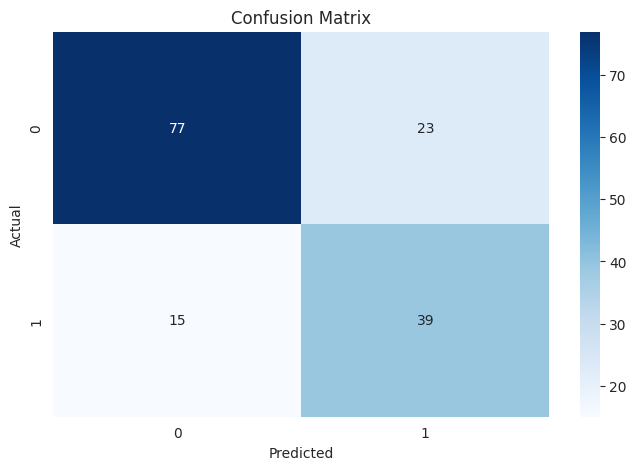

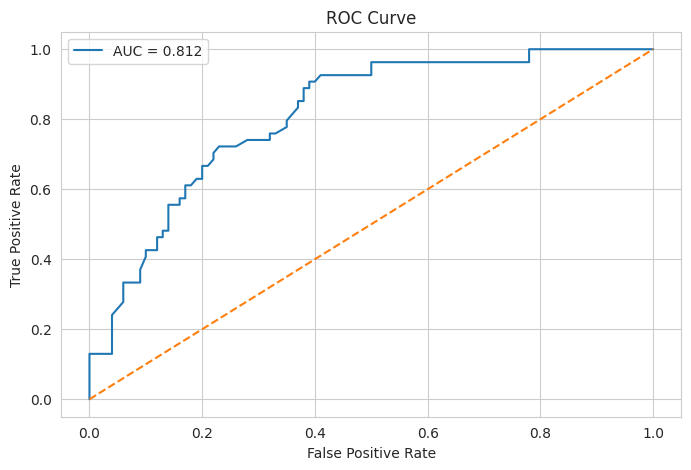

In [10]:
# Predictions
y_pred = best_model.predict(X_test_scaled)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_scaled)[:,1]
else:
    y_proba = None

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_val = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend()
    plt.title("ROC Curve")
    plt.show()


Glucose                     0.258353
BMI                         0.171483
Age                         0.127045
DiabetesPedigreeFunction    0.111577
Insulin                     0.094186
BloodPressure               0.081751
Pregnancies                 0.079829
SkinThickness               0.075775
dtype: float64


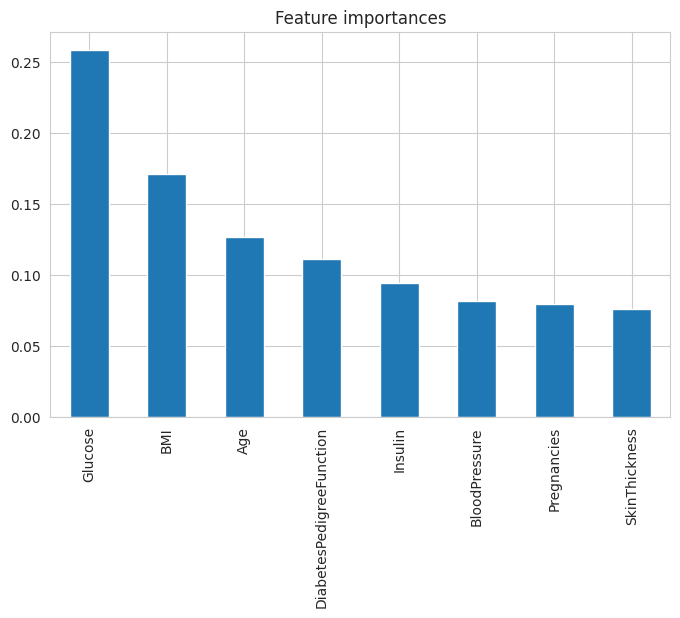

In [11]:
if hasattr(best_model, "feature_importances_"):
    fi = pd.Series(best_model.feature_importances_, index=feature_names).sort_values(ascending=False)
    print(fi.head(15))
    fi.head(15).plot.bar()
    plt.title("Feature importances")
    plt.show()
else:
    print("Model does not expose feature_importances_.")


SHAP TreeExplainer failed (maybe incompatible model). Error: index 704 is out of bounds for axis 0 with size 614


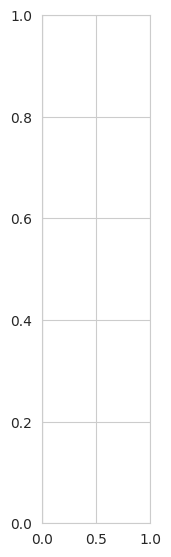

In [12]:
# For tree models, use TreeExplainer
try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train)  # note: pass unscaled or scaled depending on model; we used scaled inputs so pass X_train_res? We'll use scaled
    # If using scaled data for training
    shap.initjs()
    # Summary plot (global)
    shap.summary_plot(explainer.shap_values(X_train_res), X_train, feature_names=feature_names)  # interactive plot in notebook
except Exception as e:
    print("SHAP TreeExplainer failed (maybe incompatible model). Error:", e)
    # Fallback: use KernelExplainer (slower) or skip


In [13]:
os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(scaler, "model_artifacts/scaler.joblib")
joblib.dump(best_model, "model_artifacts/best_model.joblib")
print("Saved scaler and model to model_artifacts/")


Saved scaler and model to model_artifacts/


In [14]:
def predict_from_dict(input_dict, scaler_path="model_artifacts/scaler.joblib", model_path="model_artifacts/best_model.joblib"):
    """
    input_dict: dictionary mapping the 8 original features to numeric values
    """
    scaler = joblib.load(scaler_path)
    model  = joblib.load(model_path)

    # DataFrame with correct feature order
    X_input = pd.DataFrame([input_dict], columns=feature_names)

    # Scale and predict
    X_scaled = scaler.transform(X_input)
    pred = model.predict(X_scaled)[0]
    proba = model.predict_proba(X_scaled)[0][1] if hasattr(model, "predict_proba") else None
    return pred, proba


In [15]:
# Interactive input - only 8 original features
original_features = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"
]

print("Enter patient details. Press Enter after each value.")
input_values = {}
for feat in original_features:
    while True:
        val = input(f"{feat}: ").strip()
        try:
            fv = float(val)
            input_values[feat] = fv
            break
        except ValueError:
            print("Please enter a numeric value (e.g., 85 or 21.5).")

pred, proba = predict_from_dict(input_values)
label = "Diabetic" if pred == 1 else "Not Diabetic"
if proba is not None:
    print(f"\nPrediction: {label} (probability of diabetes = {proba:.3f})")
else:
    print(f"\nPrediction: {label}")


Enter patient details. Press Enter after each value.


KeyboardInterrupt: Interrupted by user